In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/starter-pickled-glove-840b-300d/__results__.html
/kaggle/input/starter-pickled-glove-840b-300d/__notebook__.ipynb
/kaggle/input/starter-pickled-glove-840b-300d/__output__.json
/kaggle/input/starter-pickled-glove-840b-300d/custom.css
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/tokenization.py
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/__results__.html
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/perfect_submission.csv
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/train.pkl
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/test.pkl
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/__notebook__.ipynb
/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert/__output__.json

In [15]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub


print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

ModuleNotFoundError: No module named 'tokenization'

# 1. Loading dataset (Disaster Tweets)

In [17]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Pre-Processing the dataset

In [19]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


### - Missing Values

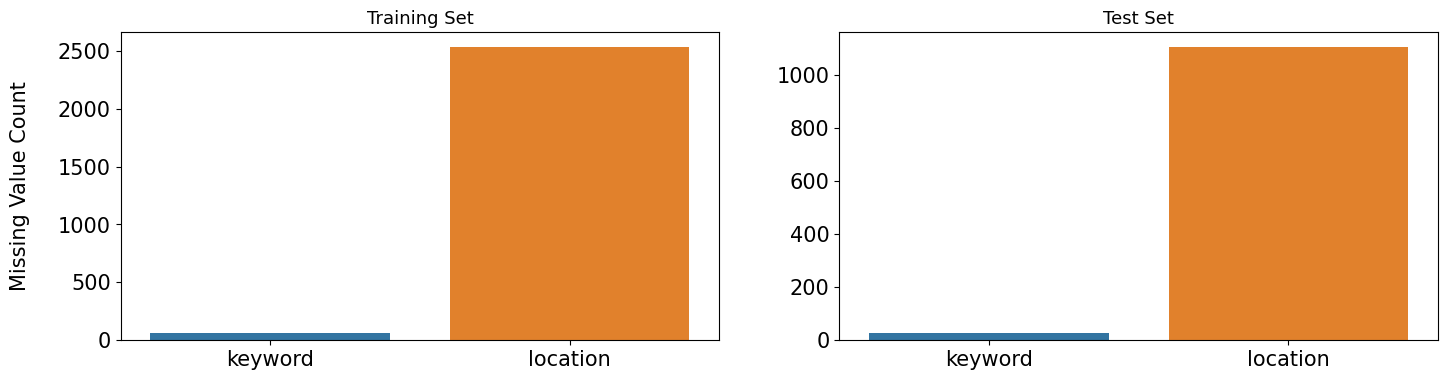

In [20]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

### Feature Engineering

#### -  Cardinality and Target Distribution

In [21]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


In [23]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [24]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [25]:
!pip install transformers datasets accelerate -q
!pip install torch scikit-learn

ERROR: Could not find a version that satisfies the requirement fsspec<=2025.3.0,>=2023.1.0 (from datasets) (from versions: none)
ERROR: No matching distribution found for fsspec<=2025.3.0,>=2023.1.0
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" (from torch) (from versions: none)
ERROR: No matching distribution found for nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64"


### Target and N-Grams
### Target

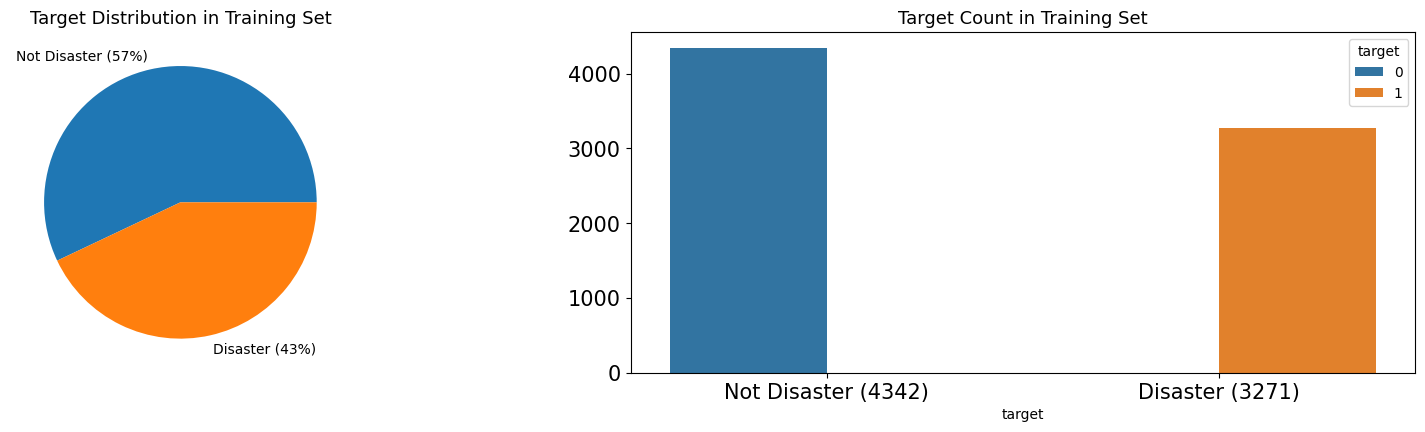

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

## Implicit Terms vs Explicit Terms

In [50]:
from collections import defaultdict
from wordcloud import STOPWORDS

DISASTER_TWEETS = df_train['target'] == 1
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

## Implicit Terms

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


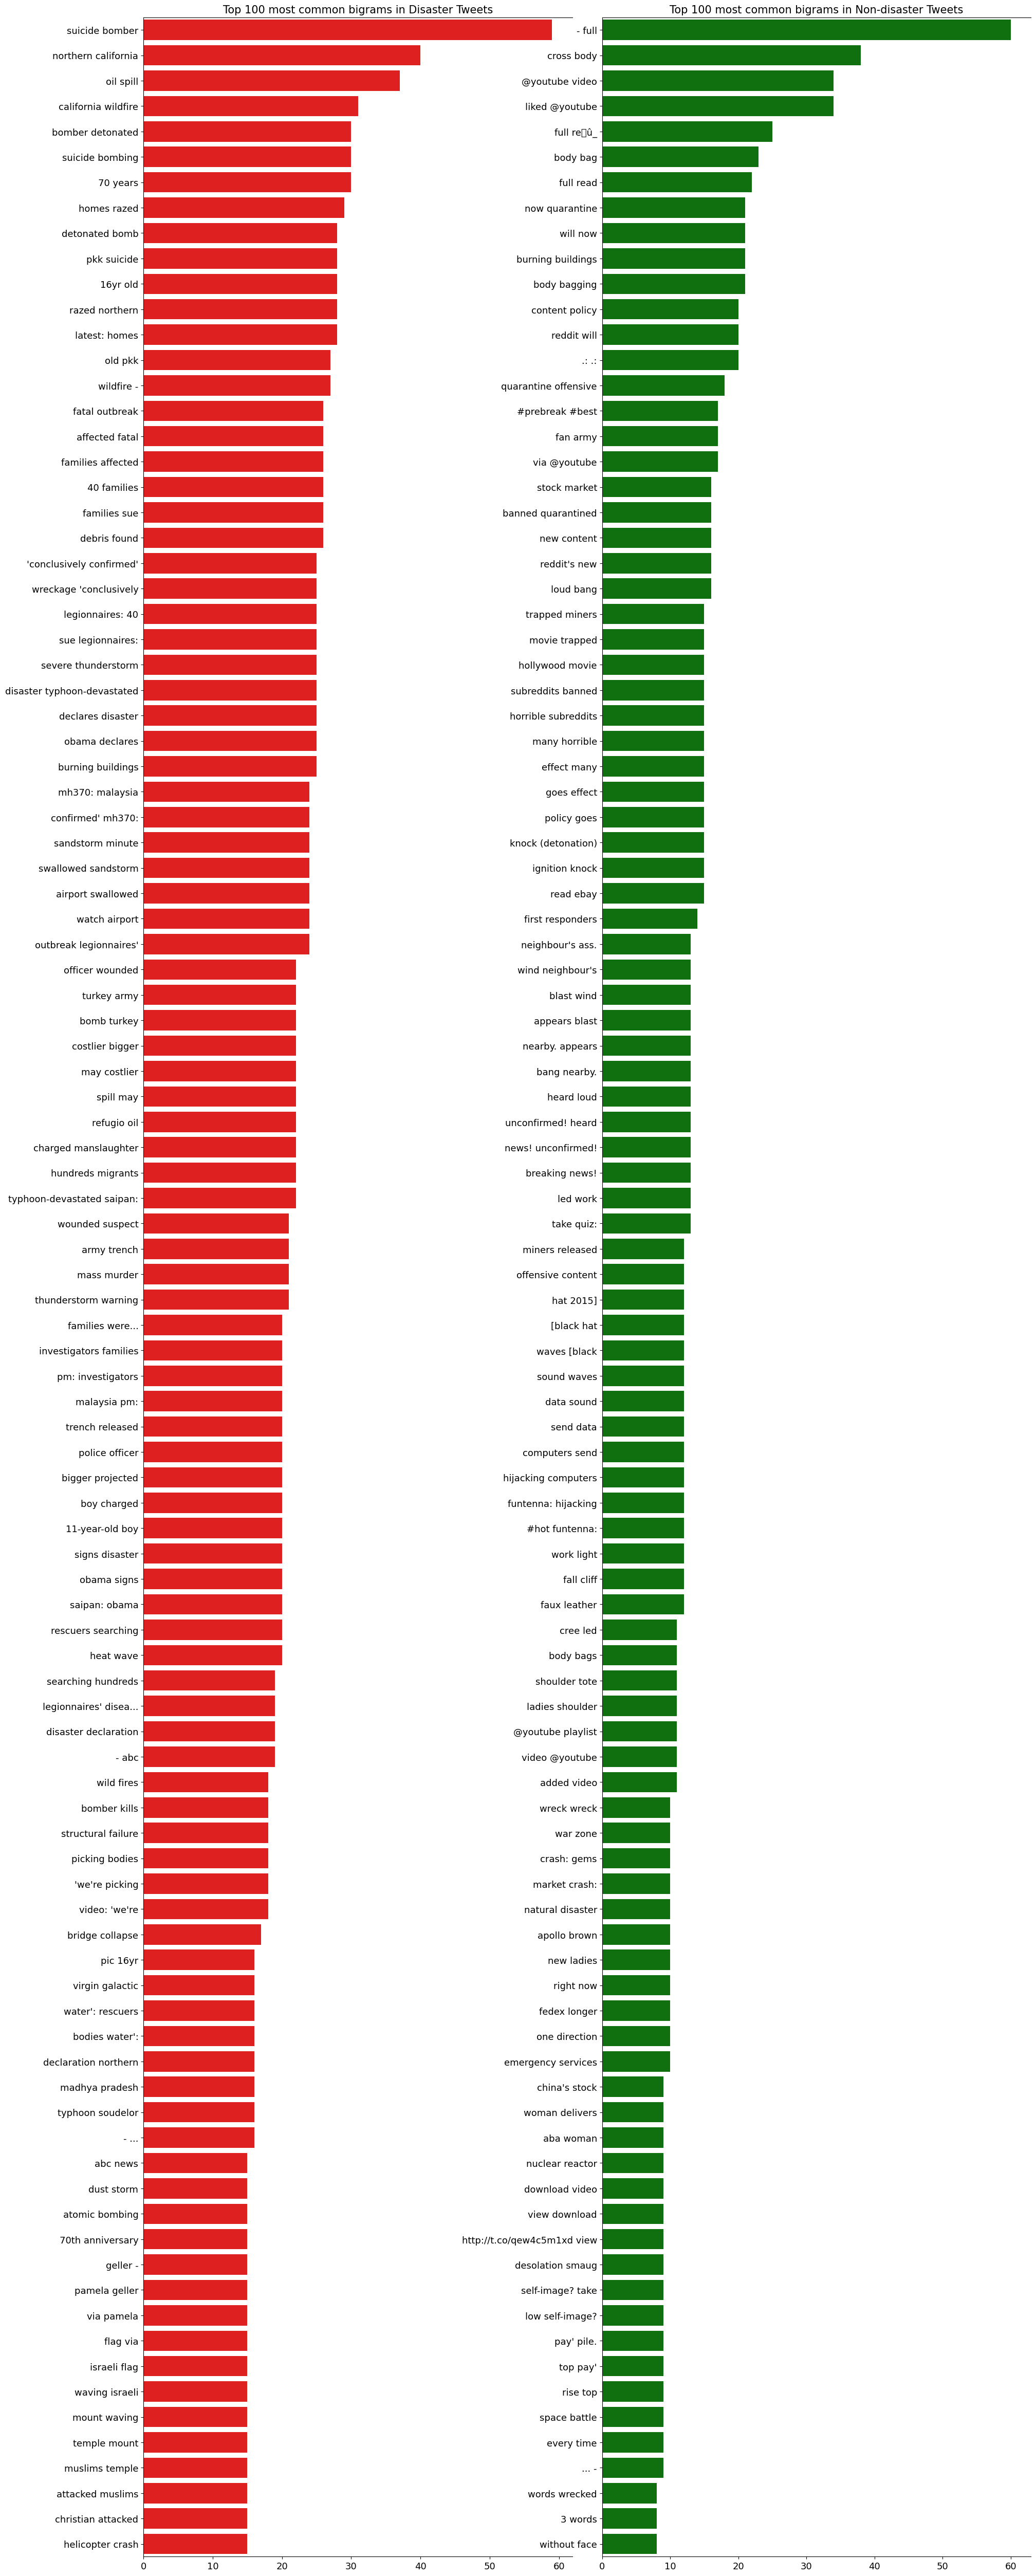

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## Explicit Terms

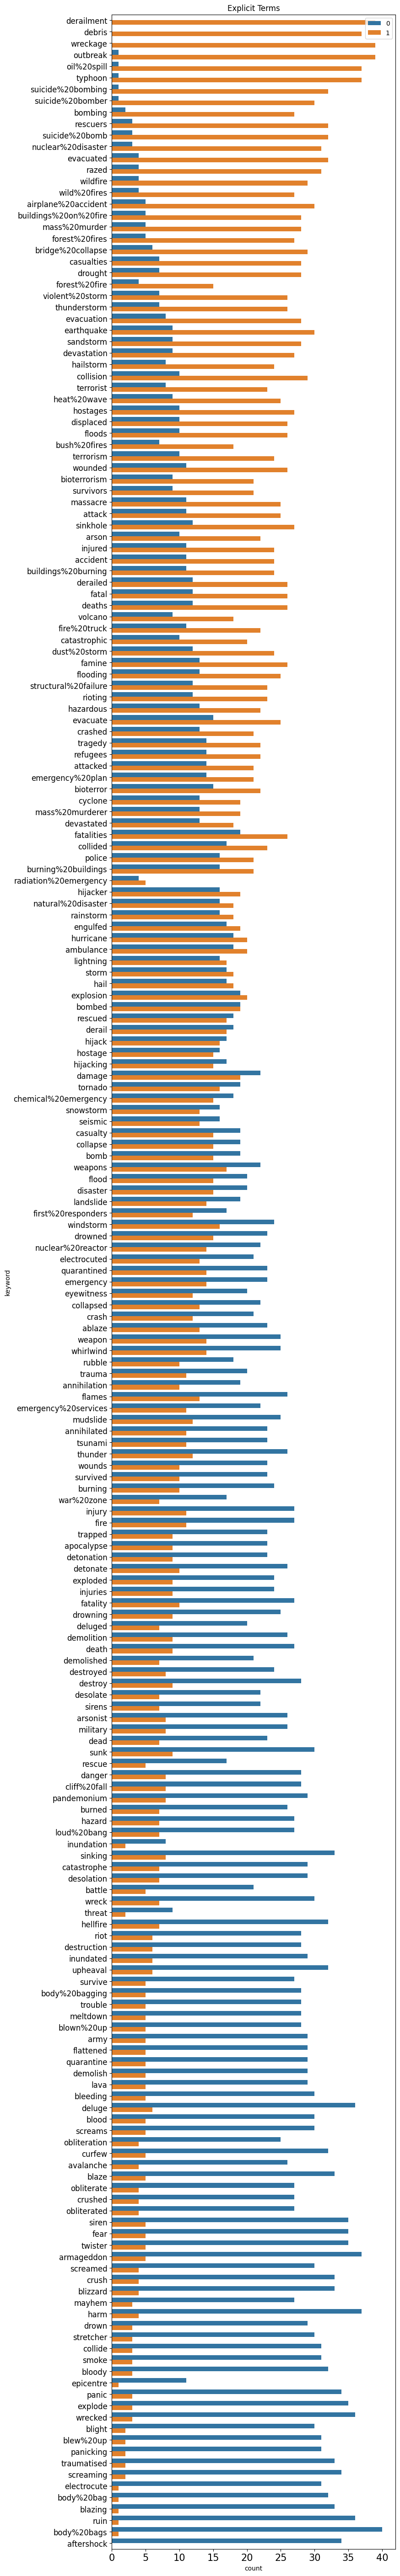

In [41]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Explicit Terms')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [29]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

2025-08-10 21:53:01.406737: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

## Model

In [62]:
from tensorflow.keras.callbacks import Callback
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super().__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs=None):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  


In [67]:
%%time

import tensorflow_hub as hub

bert_layer = hub.KerasLayer('/kaggle/input/bert/tensorflow2/en-uncased-l-12-h-768-a-12/1', trainable=True)


CPU times: user 19.8 s, sys: 771 ms, total: 20.6 s
Wall time: 20.5 s


## Training Model and Fine Tuning

In [34]:
import keras

# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3609s 19s/step - accuracy: 0.7390 - loss: 0.5630 - val_accuracy: 0.8404 - val_loss: 0.3957
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3505s 18s/step - accuracy: 0.8422 - loss: 0.3796 - val_accuracy: 0.8477 - val_loss: 0.3832


## Evaluation and Prediction

In [53]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
            y_trn = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

In [82]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

clf.train(df_train)

NameError: name 'tokenization' is not defined

### F-Score

In [35]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 873s 5s/step


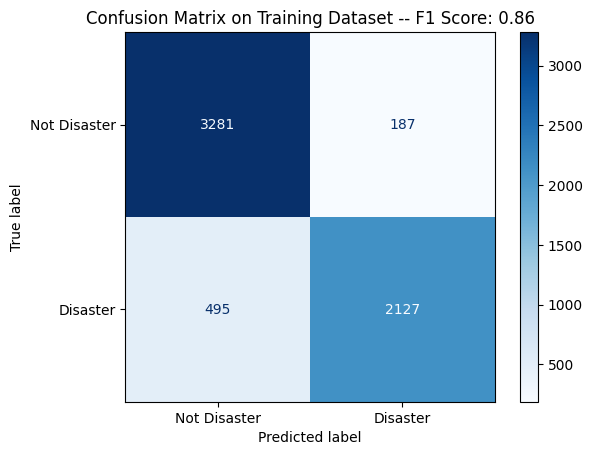

In [36]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step


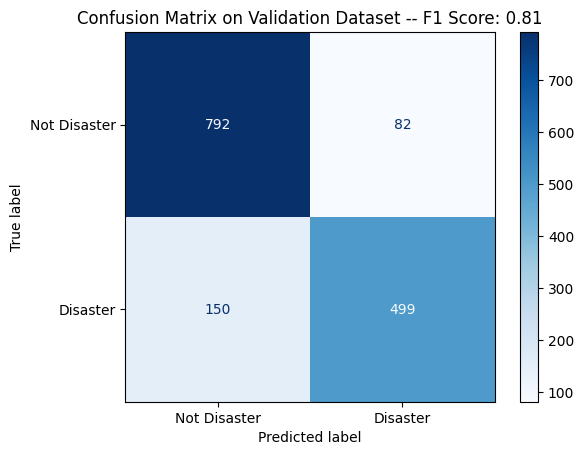

In [37]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")